Lorenzo Wormer, 1923031, 21.01.2021

# TMB: Exercize sheet 4

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import eSBMTools as esbm

In [2]:
temperatures = {
    "2ci2": [120, 129, 140], 
    "1l2y": [80, 120, 140]
}

**The \*.pdb files for all proteins have to be placed into the folder ./proteins (relative to the location of the jupyter notebook). This folder must only contain the \*.pdb files of the proteins to be simulated, nothing else.**

## Prepare folder structure

In [3]:
%%bash

# Create a directory to place all generated files in (and delete old one, if exists):
[ -d runs ] && rm -Rf runs
mkdir runs

# Loop over all *.pdb files in the ./proteins directory and create a folder in ./runs for each one:
cd proteins
for p in *.pdb
do
    # Extract the filename (without extension):
    p_id="${p%.*}"
    # Create respective directory in ./runs:
    mkdir ../runs/$p_id
    # Copy the *.pdb file into the new directory:
    cp $p ../runs/$p_id
done
cd ../

In [4]:
# Get list of proteins from the just-created ./runs directory:
proteins = os.listdir("./runs")

## Exercize 1

### (a) and (b)

In [5]:
for protein in proteins:
    p_path = "runs/{}/".format(protein)

    esbm.GoModel.createGoModelCA(p_path, protein)
    
    # Create an mdp dict for each temperature to be simulated:
    for T in temperatures[protein]:
        mdp_dict = esbm.MdpFile.createDefaultMdp("CA")
        mdp_dict["cutoff-scheme"] = "group"
        mdp_dict["nstxout"] = 10000
        mdp_dict["nstlog"] = 10000
        mdp_dict["ref_t"] = T
        mdp_dict["gen_temp"] = T

        # Write *.mdp file into the protein's directory in ./runs:
        esbm.MdpFile.writeMdpFile(p_path, "{}.mdp".format(T), mdp_dict)


### (c)

In [6]:
esbm.GoModel.writeTableCA("./")

## Exercize 2

### (a), (b) and (c)

In [7]:
%%bash

# Make gromacs command available:
source /usr/local/gromacs/bin/GMXRC

cd runs
# Run the simulation and all post-processing for each protein-temperature combination:
# (This will take about 10 minutes with no live output)
for p in *
do
    cd $p
    for T_file in *.mdp
    do
        # Create a subdirectory for each temperature, in which to save results:
        T="${T_file%.*}"
        ! [ -d $T ] && mkdir $T
        cd $T
        # Simulation:
        gmx grompp -f ../$T_file -c ../start.gro -p ../start.top -o run.tpr
        gmx mdrun -v -s run.tpr -table ../../../table.xvg -tablep ../../../table.xvg
        # Post processing with user-input piped in:
        printf "System\nSystem\n" | gmx rms -s ../start.gro -f traj_comp.xtc
        printf "Potential\n" | gmx energy -f ener.edr
        cd ../
    done
    cd ../
done
cd ../

it
under the terms of the GNU Lesser General Public License
as published by the Free Software Foundation; either version 2.1
of the License, or (at your option) any later version.

GROMACS:      gmx grompp, VERSION 5.1.5
Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Command line:
  gmx grompp -f ../129.mdp -c ../start.gro -p ../start.top -o run.tpr

Replacing old mdp entry 'nstxtcout' by 'nstxout-compressed'
Replacing old mdp entry 'xtc_grps' by 'compressed-x-grps'

NOTE 1 [file ../129.mdp]:
  The group cutoff scheme is deprecated since GROMACS 5.0 and will be
  removed in a future release when all interaction forms are supported for
  the verlet scheme. The verlet scheme already scales better, and it is
  compatible with GPUs and other accelerators.

Generated 1 of the 1 non-bonded parameter combinations
Excluding 3 bonded neighbours molecule type 'Macromolecule'
Velocities were taken from a Maxwell distribution at 129 K
Number of degrees of freedom in T-Co

### Read the generated 'energy.xvg' files and plot them

In [8]:
data = {}

# Open the energy.xvg output file of each simulation and transform it into a numpy array:
for p in proteins:
    data[p] = {}
    for T in temperatures[p]:
        with open("./runs/{}/{}/energy.xvg".format(p, T)) as f:
            data[p][T] = np.array(
                # Read line by line and split each line by spaces, if it doesn't start with "@" or "#":
                [line.split() for line in f if line[0] != "@" and line[0] != "#"], 
                dtype="float"
            )

data.keys()

['1l2y', '2ci2']

In [9]:
def plot_protein(p):
    """
    Generate a subplot for each temperature, that the input protein p has been simulated in.

    Parameters:
    ------
    p : string
        The protein for which to plot each temperature
    """

    p_data = data[p]

    # Create a figure with a height, such that each subplot will be 3 high:
    fig = plt.figure(figsize=(16, 4 * len(p_data)))
    # Add a title for the entire plot:
    fig.suptitle("Potential for protein '{}'".format(p), fontsize=20)

    # Create a subplot at the right position for each temperature:
    for i, T in enumerate(p_data):
        ax = fig.add_subplot(len(p_data), 1, i+1)
        ax.set_title("T={}".format(T))
        # Plot the overall potential over the course of the simulation:
        plt.plot(data[p][T][:,0], data[p][T][:,1])

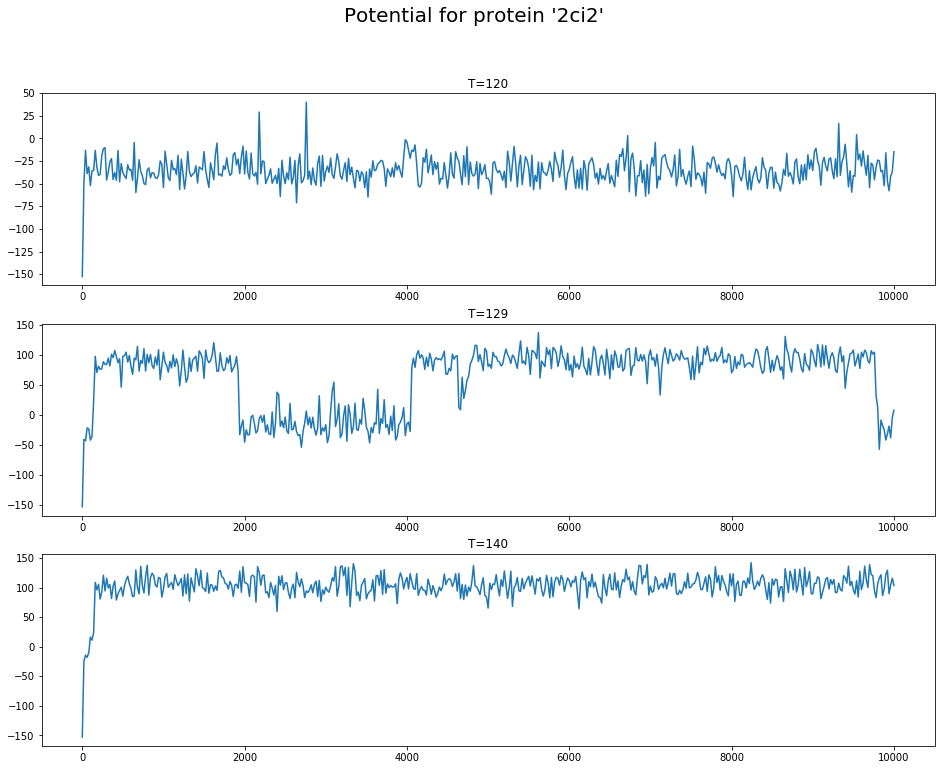

In [10]:
plot_protein(proteins[0])

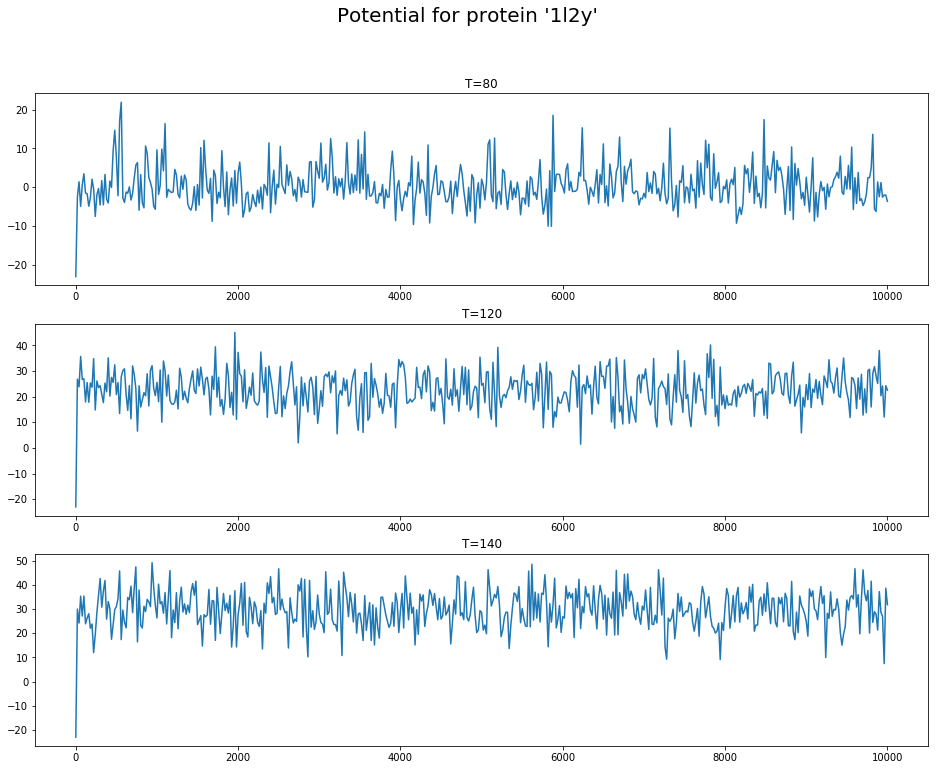

In [11]:
plot_protein(proteins[1])